<a href="https://colab.research.google.com/github/Juanes1793/Proyectos-Data-Science/blob/main/Google_Colabs/Time_Series/Series_de_tiempo_LSTM%2C_BI_LSTM%2CPercentr%C3%B3n_Multicapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de tiempo utilizando varios modelos de machine learning

El objetivo de este colab es mostrar algunos tipos de modelos de machine learning para la predicción de datos utilizando técnicas basadas en series de tiempo. Nos enfocaremos en la predicción de la demanda de consumo de una microrred.

Se instalan algunas librerías importantes para la graficación de los datos

In [1]:
!pip install -U plotly
!pip install -U kaleido # Necesitamos esta librería para exportar las visualizaciones como imágenes estáticas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.2 MB 4.3 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


# Se importan las librerías que se van a usar

In [2]:
import numpy as np 
import plotly
# data in/out & eda
import pandas as pd 
import pandas_profiling
from pandas_profiling import ProfileReport
# visualisations
import plotly.graph_objs as go 
import plotly.express as px
import matplotlib.pyplot as plt
#import plotly.express as px
import plotly.graph_objects as go

In [3]:
url = "https://raw.githubusercontent.com/Juanes1793/Proyectos-Data-Science/main/Base_datos/DemandCharge.csv"
#df = pd.read_csv("DemandCharge.csv")
df = pd.read_csv(url)
df_1 = df.copy()
df_1.rename(columns = {'TotalCampusLoad':'Demanda_Campus'}, inplace = True) 
df_1['DateTime'] = pd.to_datetime(df_1.DateTime)
df_1.drop(['OnCampusGeneration', 'SDG&E Import',"AdjustedDemand"], axis=1,inplace = True)
df_1.sort_values(by=['DateTime'], axis=0, ascending=True, inplace=True) 
df_1.reset_index(inplace=True, drop=True)
df_1



,DateTime,Demanda_Campus
0,2018-01-01 00:00:00,28947.06
1,2018-01-01 00:15:00,28779.14
2,2018-01-01 00:30:00,28737.36
3,2018-01-01 00:45:00,28700.43
4,2018-01-01 01:00:00,28648.00
...,...,...
75839,2020-02-29 22:45:00,31552.81
75840,2020-02-29 23:00:00,31364.09
75841,2020-02-29 23:15:00,31236.65
75842,2020-02-29 23:30:00,31096.75


In [4]:
df

,DateTime,TotalCampusLoad,OnCampusGeneration,SDG&E Import,AdjustedDemand
0,2/29/2020 23:45,31650.58,30752.804,897.774,-305.422
1,2/29/2020 23:30,31096.75,30750.037,346.711,-859.252
2,2/29/2020 23:15,31236.65,30614.898,621.749,-719.353
3,2/29/2020 23:00,31364.09,30866.657,497.427,-591.916
4,2/29/2020 22:45,31552.81,30785.978,766.840,-403.182
...,...,...,...,...,...
75839,1/1/2018 1:00,28648.00,17144.323,12455.270,-2356.407
75840,1/1/2018 0:45,28700.43,17106.156,12450.270,-2399.574
75841,1/1/2018 0:30,28737.36,17342.170,12528.160,-2085.670
75842,1/1/2018 0:15,28779.14,17388.247,12577.250,-1990.503


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75844 entries, 0 to 75843
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTime        75844 non-null  datetime64[ns]
 1   Demanda_Campus  75844 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 MB


**Comprobamos** si hay valores nulos en el dataFrame

In [6]:
df_1.isnull().sum()

DateTime          0
Demanda_Campus    0
dtype: int64

Como se puede ver, no se tienen valores nulos por lo que es posible continuar con el análisis del DataFrame

# Descripción de los datos

Si se observa la siguiente tabla, se pueden ver algunas descripciones a nivel general de los datos, el número de entradas que son 75844 . La media del consumo de la microrred desde el 1 de Enero del 2018 hasta el 29 de Febrero del 2020 fue de 34415.848772. También se puede apreciar la desviación estándar, los percentiles principales y los datos en que han menor y mayor consumo de la microrred, siendo 26100.030000 y 51437.470000 los valores respectivos

In [7]:
df_1.describe()

,Demanda_Campus
count,75844.000000
mean,34415.848772
std,3468.573704
min,26100.030000
25%,31696.012500
50%,34020.380000
75%,36604.507500
max,51437.470000


# Limpieza del data Set

In [8]:
#Se eliminan los datos repetidos en base a la columna "DateTime" conservando el último valor
df_1.drop_duplicates(subset='DateTime', keep='last', inplace=True)


# Encontrar y llenar los datos de fecha por hora

In [9]:
df_1 = df_1.set_index('DateTime')
print(f'df_1.index.freq is set to: {df_1.index.freq}')  # Comando utilizado para determinar la continuidad del Dataset si es en horas/dias, etc

df_1.index.freq is set to: None


# Opcional

In [10]:
## Rango personalizado
#date_range = pd.date_range(start=min(df_1.index), 
#                           end=max(df_1.index), 
#                           freq='H')
#
#print(f'La diferencia de longitud entre el intervalo de fechas personalizado y nuestro conjunto de datos es {(len(date_range)-len(df_1))}:')
#print(date_range.difference(df_1.index))

In [11]:
## esto agregará las fechas y horas por si habían datos que faltaban anteriormente y creará valores nulos en nuestra variable de destino
#df_1 = df_1.reindex(date_range)
#
## llenamos los espacios en blanco con valores que se encuentran en una curva lineal entre puntos de datos existentes
#df_1['Consumo'].interpolate(method='linear', inplace=True)
#
## ahora tenemos un índice de fecha y hora claramente continuo
#print(f'El df_1.index.freq es ahora: {df_1.index.freq}, indicando que ya tenemos valores continuos')

In [12]:
df_1

,Demanda_Campus
DateTime,
2018-01-01 00:00:00,28947.06
2018-01-01 00:15:00,28779.14
2018-01-01 00:30:00,28737.36
2018-01-01 00:45:00,28700.43
2018-01-01 01:00:00,28648.00
...,...
2020-02-29 22:45:00,31552.81
2020-02-29 23:00:00,31364.09
2020-02-29 23:15:00,31236.65


# Datos resumidos por año, mes y día


En este caso podemos resumir los datos por varias categorías como lo dice el título, por año, por mes , por día. Podemos ver la media de los datos por estas categorías, inclusive podemos ver el mínimo, máximo y el total de datos. Solamente con cambiar un comando los cuales son max = para dato máximo , min = dato mínimo. mean = media de los datos y sum para sumar los datos de una categoría.

In [13]:
df_1.resample("m").sum().head(100)

,Demanda_Campus
DateTime,
2018-01-31,9.872266e+07
2018-02-28,8.884071e+07
2018-03-31,9.713170e+07
2018-04-30,9.584761e+07
2018-05-31,9.920942e+07
2018-06-30,9.871209e+07
2018-07-31,1.132420e+08
2018-08-31,1.201295e+08
2018-09-30,1.029976e+08


# Se distribuyen los datos entre varias Columnas, ya sea de fecha, hora, día de la semana, etc

In [14]:
# Se toman los valores de la columna "DateTime" convertida a índice 
df_1['Dia_semana'] = df_1.index.dayofweek                                 
df_1['Dia_año'] = df_1.index.dayofyear
df_1['Año'] = df_1.index.year
df_1['Mes'] = df_1.index.month
df_1['Hora'] = df_1.index.hour
df_1['Nombre_Dia'] = df_1.index.day_name()
df_1['Semana_Año'] = df_1.index.weekofyear
df_1['Dia_Mes'] = df_1.index.day # Day of Month
df_1['Fecha'] = df_1.index.date 
#Se agrega una columna adicional que representa la estación del año:
# 1)Primavera: entre el 2 y el 7 de febrero.
# 2)Verano: entre el 4 y el 10 de mayo.
# 3)Otoño: entre el 3 y el 10 de agosto.
# 4)Invierno: entre el 5 y el 10 de noviembre.
df_1['Estación_Año'] = df_1['Mes'].apply(lambda month_number: (month_number%12 + 3)//3)

df_1.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,Demanda_Campus,Dia_semana,Dia_año,Año,Mes,Hora,Nombre_Dia,Semana_Año,Dia_Mes,Fecha,Estación_Año
DateTime,,,,,,,,,,,
2018-01-01 00:00:00,28947.06,0,1,2018,1,0,Monday,1,1,2018-01-01,1
2018-01-01 00:15:00,28779.14,0,1,2018,1,0,Monday,1,1,2018-01-01,1
2018-01-01 00:30:00,28737.36,0,1,2018,1,0,Monday,1,1,2018-01-01,1
2018-01-01 00:45:00,28700.43,0,1,2018,1,0,Monday,1,1,2018-01-01,1
2018-01-01 01:00:00,28648.00,0,1,2018,1,1,Monday,1,1,2018-01-01,1


# Matriz de correlación

La matriz de correlación R es una matriz cuadrada n ´ n cosntituida por los coeficientes de correlación de cada pareja de variables; de manera que tendrá unos en su diagonal principal, y en los elementos no diagonales (i,j) los correspondientes coeficientes de correlación rij . La matriz de correlación será, obviamente, simétrica, y conservará las propiedades de ser definida-positiva y tener un determinante no negativo, ( además el determinante será siempre menor o igual que 1). Puede considerarse como la matriz de varianzas entre las variables tipificadas.

 

In [15]:
df_1.corr()

,Demanda_Campus,Dia_semana,Dia_año,Año,Mes,Hora,Semana_Año,Dia_Mes,Estación_Año
Demanda_Campus,1.000000,-0.273842,0.159453,-0.059222,0.163646,0.187755,0.181668,-0.037666,0.354353
Dia_semana,-0.273842,1.000000,0.003487,0.003932,0.003758,0.000218,0.002083,-0.003142,0.006245
Dia_año,0.159453,0.003487,1.000000,-0.235882,0.996747,-0.000135,0.979036,0.092519,0.625761
Año,-0.059222,0.003932,-0.235882,1.000000,-0.238067,-0.000026,-0.231991,-0.003923,-0.222168
Mes,0.163646,0.003758,0.996747,-0.238067,1.000000,-0.000127,0.977442,0.012244,0.629002
Hora,0.187755,0.000218,-0.000135,-0.000026,-0.000127,1.000000,-0.000138,-0.000086,-0.000049
Semana_Año,0.181668,0.002083,0.979036,-0.231991,0.977442,-0.000138,1.000000,0.071202,0.641660
Dia_Mes,-0.037666,-0.003142,0.092519,-0.003923,0.012244,-0.000086,0.071202,1.000000,0.006764
Estación_Año,0.354353,0.006245,0.625761,-0.222168,0.629002,-0.000049,0.641660,0.006764,1.000000


# Mapa de calor

In [16]:
px.imshow(df_1.corr())

# Visualización de Datos

# Consumo de la Microrred

In [17]:
# plotly doesn't allow us to access the index, so let's copy it into a column 
df_1['date_and_time'] = df_1.index

# plotting
fig = px.line(df_1,
              x='date_and_time',
              y='Demanda_Campus',
              title="Consumo_Microrred")
fig.update_traces(line=dict(width=0.5))
fig.update_layout(xaxis_title='Fecha & Hora (yyyy/mm/dd hh:MM)',
                  yaxis_title='Consumo_Microrred')
fig.show()

#Media de consumo de la microrred por semana

In [18]:
# aggregated data
_ = df_1\
    .groupby(['Hora', 'Nombre_Dia'], as_index=False)\
    .agg({'Demanda_Campus':'median'})

# plotting
fig = px.line(_, 
              x='Hora', 
              y='Demanda_Campus', 
              color='Nombre_Dia', 
              title='Media de consumo de la microrred por semana')
fig.update_layout(xaxis_title='Hora',
                  yaxis_title='Consumo_Microrred')
fig.show()

# Media de consumo de la microrred por Estaciones del Año 

In [19]:
# aggregated data
_ = df_1\
    .groupby(['Hora', 'Estación_Año'], as_index=False)\
    .agg({'Demanda_Campus':'median'})

# plotting
fig = px.line(_,
              x='Hora', 
              y='Demanda_Campus', 
              color='Estación_Año', 
              title='Media de consumo de la microrred por Estaciones del Año')
fig.update_layout(xaxis_title='Hora',
                  yaxis_title='Consumo de la Microrred')
fig.show()

#Predicción de la demanda usando LSTM univariable

In [20]:
import tensorflow as tf
import os 

In [21]:
df_2 = df.copy()
df_2.rename(columns = {'TotalCampusLoad':'Demanda_Campus'}, inplace = True)
df_2

,DateTime,Demanda_Campus,OnCampusGeneration,SDG&E Import,AdjustedDemand
0,2/29/2020 23:45,31650.58,30752.804,897.774,-305.422
1,2/29/2020 23:30,31096.75,30750.037,346.711,-859.252
2,2/29/2020 23:15,31236.65,30614.898,621.749,-719.353
3,2/29/2020 23:00,31364.09,30866.657,497.427,-591.916
4,2/29/2020 22:45,31552.81,30785.978,766.840,-403.182
...,...,...,...,...,...
75839,1/1/2018 1:00,28648.00,17144.323,12455.270,-2356.407
75840,1/1/2018 0:45,28700.43,17106.156,12450.270,-2399.574
75841,1/1/2018 0:30,28737.36,17342.170,12528.160,-2085.670
75842,1/1/2018 0:15,28779.14,17388.247,12577.250,-1990.503


In [22]:
df_2['DateTime'] = pd.to_datetime(df_2.DateTime)
df_2.sort_values(by=['DateTime'], axis=0, ascending=True, inplace=True)
df_2.reset_index(inplace=True, drop=True)
df_2 = df_2.set_index('DateTime')
df_2

,Demanda_Campus,OnCampusGeneration,SDG&E Import,AdjustedDemand
DateTime,,,,
2018-01-01 00:00:00,28947.06,17082.433,12709.430,-2164.137
2018-01-01 00:15:00,28779.14,17388.247,12577.250,-1990.503
2018-01-01 00:30:00,28737.36,17342.170,12528.160,-2085.670
2018-01-01 00:45:00,28700.43,17106.156,12450.270,-2399.574
2018-01-01 01:00:00,28648.00,17144.323,12455.270,-2356.407
...,...,...,...,...
2020-02-29 22:45:00,31552.81,30785.978,766.840,-403.182
2020-02-29 23:00:00,31364.09,30866.657,497.427,-591.916
2020-02-29 23:15:00,31236.65,30614.898,621.749,-719.353


# LSTM UNIVARIADA 

Se importan las librerías que se utilizarán para la predicción de la LSTM Vanilla. Una LSTM de este tipo  tiene una un solo layer oculto de unidades de LSTM y un solo layer de salida para realizar la predicción

In [23]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Se programa una función que servirá como ventana o sliding window para nuestra serie de tiempo

In [24]:
Demanda = df_2["Demanda_Campus"]																# Se obtiene una sola columna del dataFrame que será a la que se le hace la predicción.
demanda_lista = df_2["Demanda_Campus"].tolist()									# Se convierte la columna del dataFrame a lista

n_steps = 96																										# Se usa 96 porque es el número de datos por día que se obtienen cada 15 minutos de la microrred

# Función programada para hallar el sliding window 
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 


In [25]:

X, y = split_sequence(demanda_lista,n_steps)                # Se aplica la función teniendo en cuenta los datos de la demanda y el número de pasos, en este caso 96

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X) 
y = y.reshape(-1,1)
y_scaled = scaler.fit_transform(y) 

n_features = 1                                              # Se asigna 1 porque estamos trabajando con una serie univariada
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], n_features))         # Se redimensiona el arreglo dependiendo del número de características de este y condiciones iniciales

Se reparten los datos en entrenamiento y prueba.
80% para prueba y 20% para entrenamiento






In [26]:
X_train,y_train = X_scaled[:60598],y_scaled[:60598]                        # Datos de entrenamiento
X_test,y_test = X_scaled[60598:],y_scaled[60598:]                          # Datos de prueba



In [27]:
from keras import callbacks
from keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')                   # Se entrena el modelo usando un optimizador llamado adam y que se basa en los mse 
                                                              # o error cuadrático medio 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train,y_train, epochs=10, verbose=0)               # Se entrena el modelo con la infromación del dataset usada para entrenamiento.
                                                              # epochs es el número de veces que se corre el modelo. 

In [29]:
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)                        # Se realizan las predicciones
#print(yhat)

# Importanción de librería 
from functools import reduce
Lista_predict = yhat.tolist()                                  # Se transforma el array en una nested list (lista dentro de listas) 
prediccion = reduce(lambda x,y: x+y, Lista_predict)            # Luego se transforma en una lista de una sola dimensión          


y_test = y_test.tolist()                                       # Se transforma el array en una nested list (lista dentro de listas) 
y_test1 = reduce(lambda x,y: x+y, y_test)                      # Se transforma el array en una nested list (lista dentro de listas)  

### Se escalan los datos a su valor real 

In [30]:
#Se vuelven a escalar los datos a su valor real para los datos de prueba
ytest_real = scaler.inverse_transform(y_test)
ytest_real = ytest_real.tolist()
ytest_real1 = reduce(lambda x,y: x+y, ytest_real)  

#Se vuelven a escalar los datos a su valor real para las predicciones

yreal_prediccion = scaler.inverse_transform(yhat) 
yreal_prediccion = yreal_prediccion.tolist()
yreal_prediccion1 = reduce(lambda x,y: x+y, yreal_prediccion)  





### Se muestran los datos comparados en un dataframe y en una gráfica pero de forma escalada 

In [31]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame 

train_results = pd.DataFrame(data={'Train Predictions':prediccion, 'Actuals':y_test1})
train_results

,Train Predictions,Actuals
0,0.464392,0.471415
1,0.466652,0.470885
2,0.467337,0.487558
3,0.483827,0.537897
4,0.536062,0.536020
...,...,...
15145,0.198772,0.215206
15146,0.209919,0.207758
15147,0.204354,0.202728
15148,0.199550,0.197207


Se muestra una gráfica de los  datos para ver las predicciones aproximadas escaladas

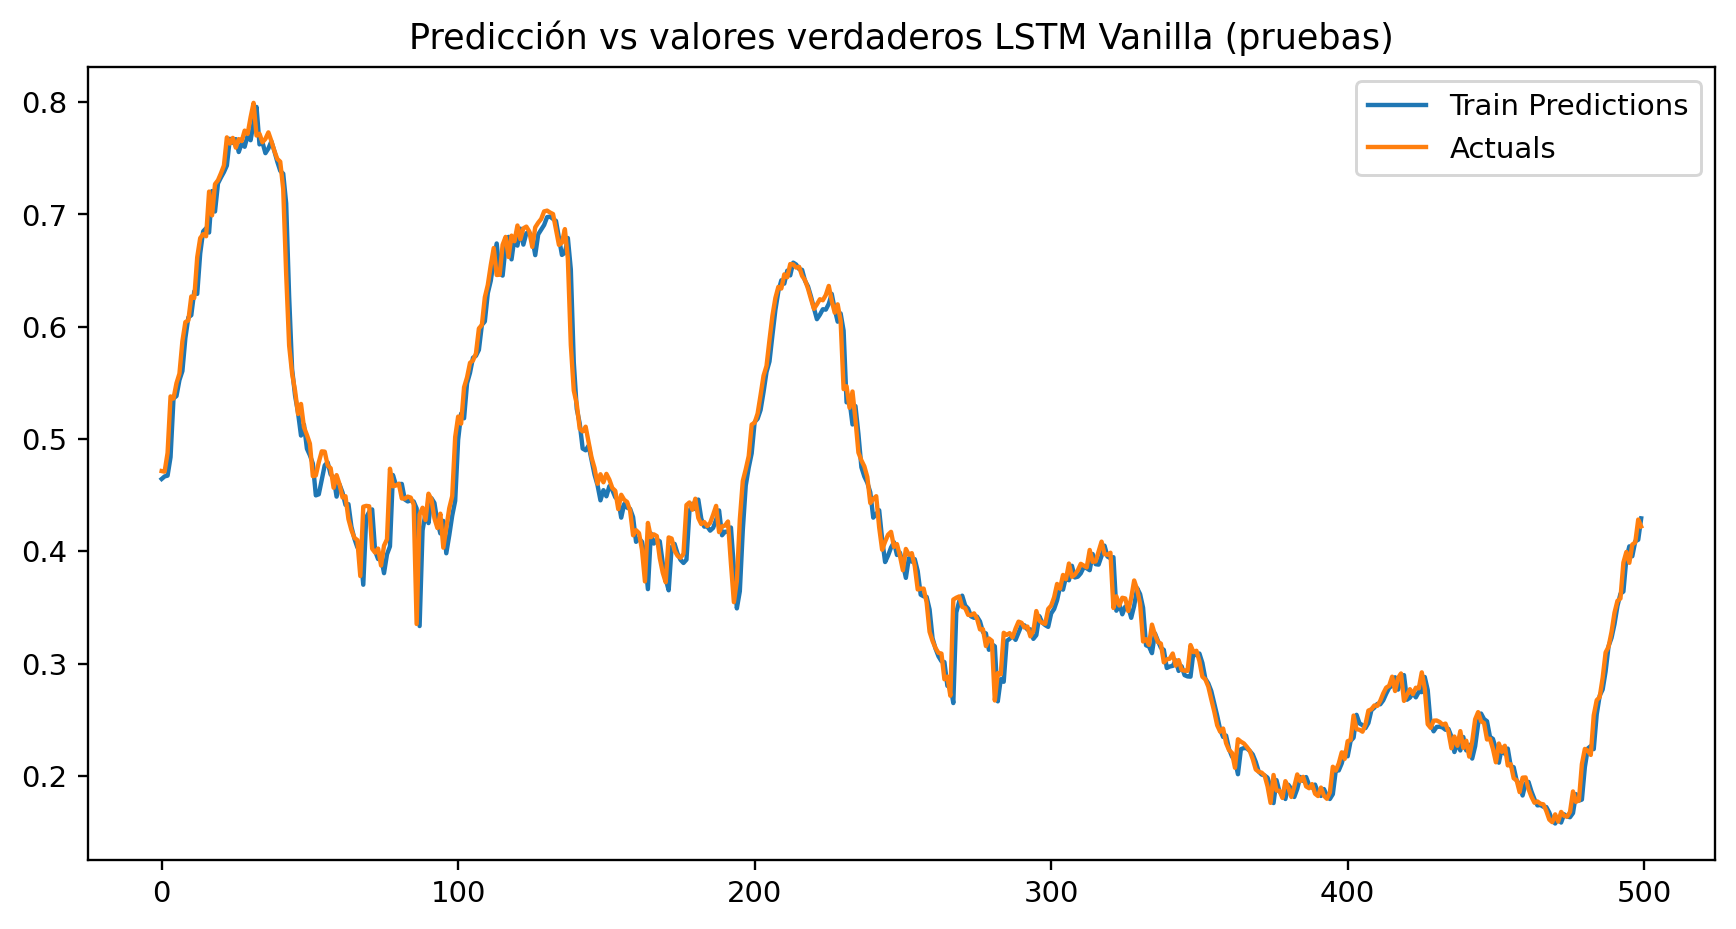

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results["Train Predictions"][:500],label="Train Predictions")
plt.plot(train_results["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos LSTM Vanilla (pruebas)")
plt.legend();

### Se muestran los datos comparados en un dataframe y en una gráfica con sus valores reales

In [33]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame 

train_results_real = pd.DataFrame(data={'Train Predictions':yreal_prediccion1, 'Actuals':ytest_real1})
train_results_real

,Train Predictions,Actuals
0,37866.535156,38044.49
1,37923.796875,38031.04
2,37941.164062,38453.51
3,38358.976562,39728.97
4,39682.464844,39681.40
...,...,...
15145,31136.408203,31552.81
15146,31418.833984,31364.09
15147,31277.847656,31236.65
15148,31156.113281,31096.75


Se muestra una gráfica de los  datos para ver las predicciones aproximadas reales

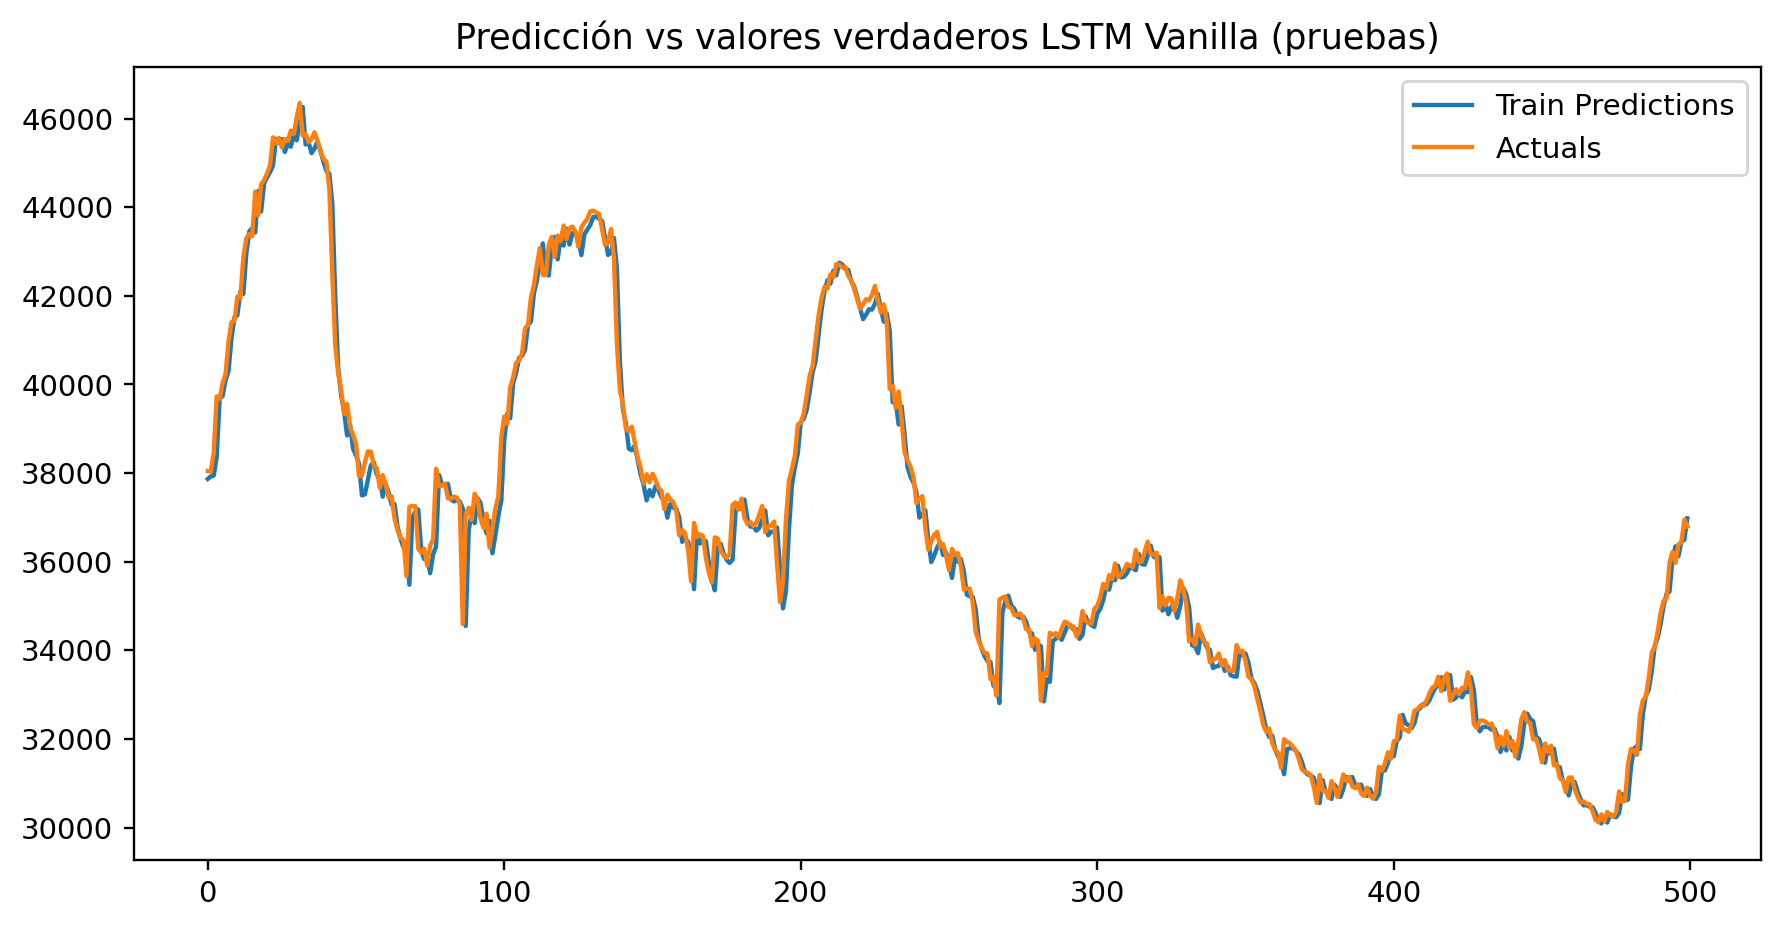

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results_real["Train Predictions"][:500],label="Train Predictions")
plt.plot(train_results_real["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos LSTM Vanilla (pruebas)")
plt.legend();

## Métricas de Medición LSTM Vanilla

Las métricas de medición en series de tiempo, muestran un resumen de la habiliddad y capacidad del pronóstico del modelo.

### Mean absolute Error

In [35]:
# calculamos mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test1, prediccion)
print('MAE: %f' % mae)

MAE: 0.009965


### Mean Squared Error

In [36]:
# calculamos mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test1, prediccion)
print('MSE: %f' % mse)

MSE: 0.000220


### Root Mean Squared Error

In [37]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(y_test1, prediccion)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.014835


###  Mean absolute percentage error (MAPE)



In [38]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
mape = mean_absolute_percentage_error(y_test1,prediccion)
print('MAPE: %f' % mape)

MAPE: 4.013348


# Bidirectional LSTM

Una bidirectional LSTM  aprende los datos de entrada tanto hacia adelante como hacia atrás y concatenar ambas interpretaciones.

In [40]:
# Se implementa la librería bidirectional 
from keras.layers import Bidirectional

In [41]:
# Se define el modelo
model1 = Sequential()
model1.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

In [42]:
# Se entrena el modelo
model1.fit(X_train,y_train, epochs=10, verbose=0)

In [43]:
# Se prueba el modelo
yhat1 = model1.predict(X_test, verbose=0)                       # Se realizan las predicciones
#print(yhat)

# Importanción de librería 
from functools import reduce
Lista_predict1 = yhat1.tolist()
prediccion1 = reduce(lambda x,y: x+y, Lista_predict1)           # Se transforma el array en una nested list (lista dentro de listas) 
                                                              # Luego se transforma en una lista de una sola dimensión

### Se escalan los datos a su valor real 

In [44]:
#Se vuelven a escalar los datos a su valor real para las predicciones

yreal_prediccion_2 = scaler.inverse_transform(yhat1) 
yreal_prediccion_2 = yreal_prediccion_2.tolist()
yreal_prediccion_21 = reduce(lambda x,y: x+y, yreal_prediccion_2)  



### Se muestran los datos comparados en un dataframe y en una gráfica pero de forma escalada 

In [45]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame 
train_results1 = pd.DataFrame(data={'Train Predictions1':prediccion1, 'Actuals':y_test1})
train_results1

,Train Predictions1,Actuals
0,0.472237,0.471415
1,0.473840,0.470885
2,0.473889,0.487558
3,0.489832,0.537897
4,0.541482,0.536020
...,...,...
15145,0.200253,0.215206
15146,0.212137,0.207758
15147,0.206304,0.202728
15148,0.201708,0.197207


Se muestra una gráfica de los  datos para ver las predicciones aproximadas

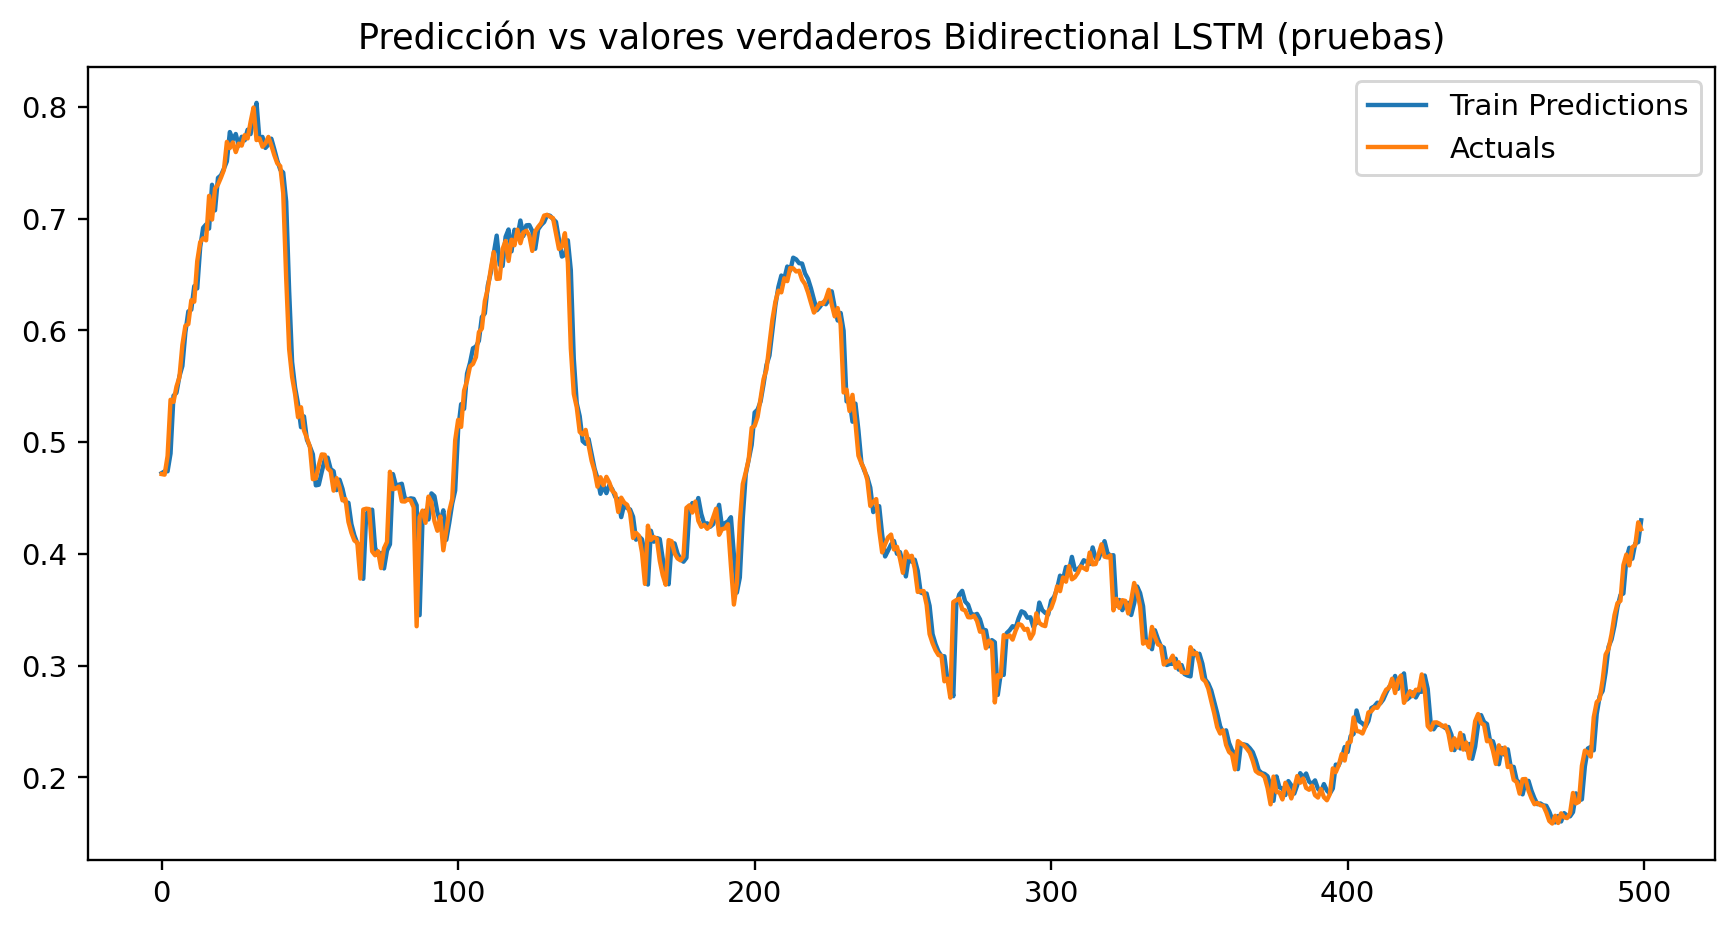

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results1["Train Predictions1"][:500],label="Train Predictions")
plt.plot(train_results1["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos Bidirectional LSTM (pruebas)")
plt.legend();

### Se muestran los datos comparados en un dataframe y en una gráfica con sus valores reales

In [47]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame 

train_results_real2 = pd.DataFrame(data={'Train Predictions':yreal_prediccion_21, 'Actuals':ytest_real1})
train_results_real2

,Train Predictions,Actuals
0,38065.296875,38044.49
1,38105.917969,38031.04
2,38107.167969,38453.51
3,38511.128906,39728.97
4,39819.804688,39681.40
...,...,...
15145,31173.916016,31552.81
15146,31475.046875,31364.09
15147,31327.253906,31236.65
15148,31210.785156,31096.75


Se muestra una gráfica de los  datos para ver las predicciones aproximadas

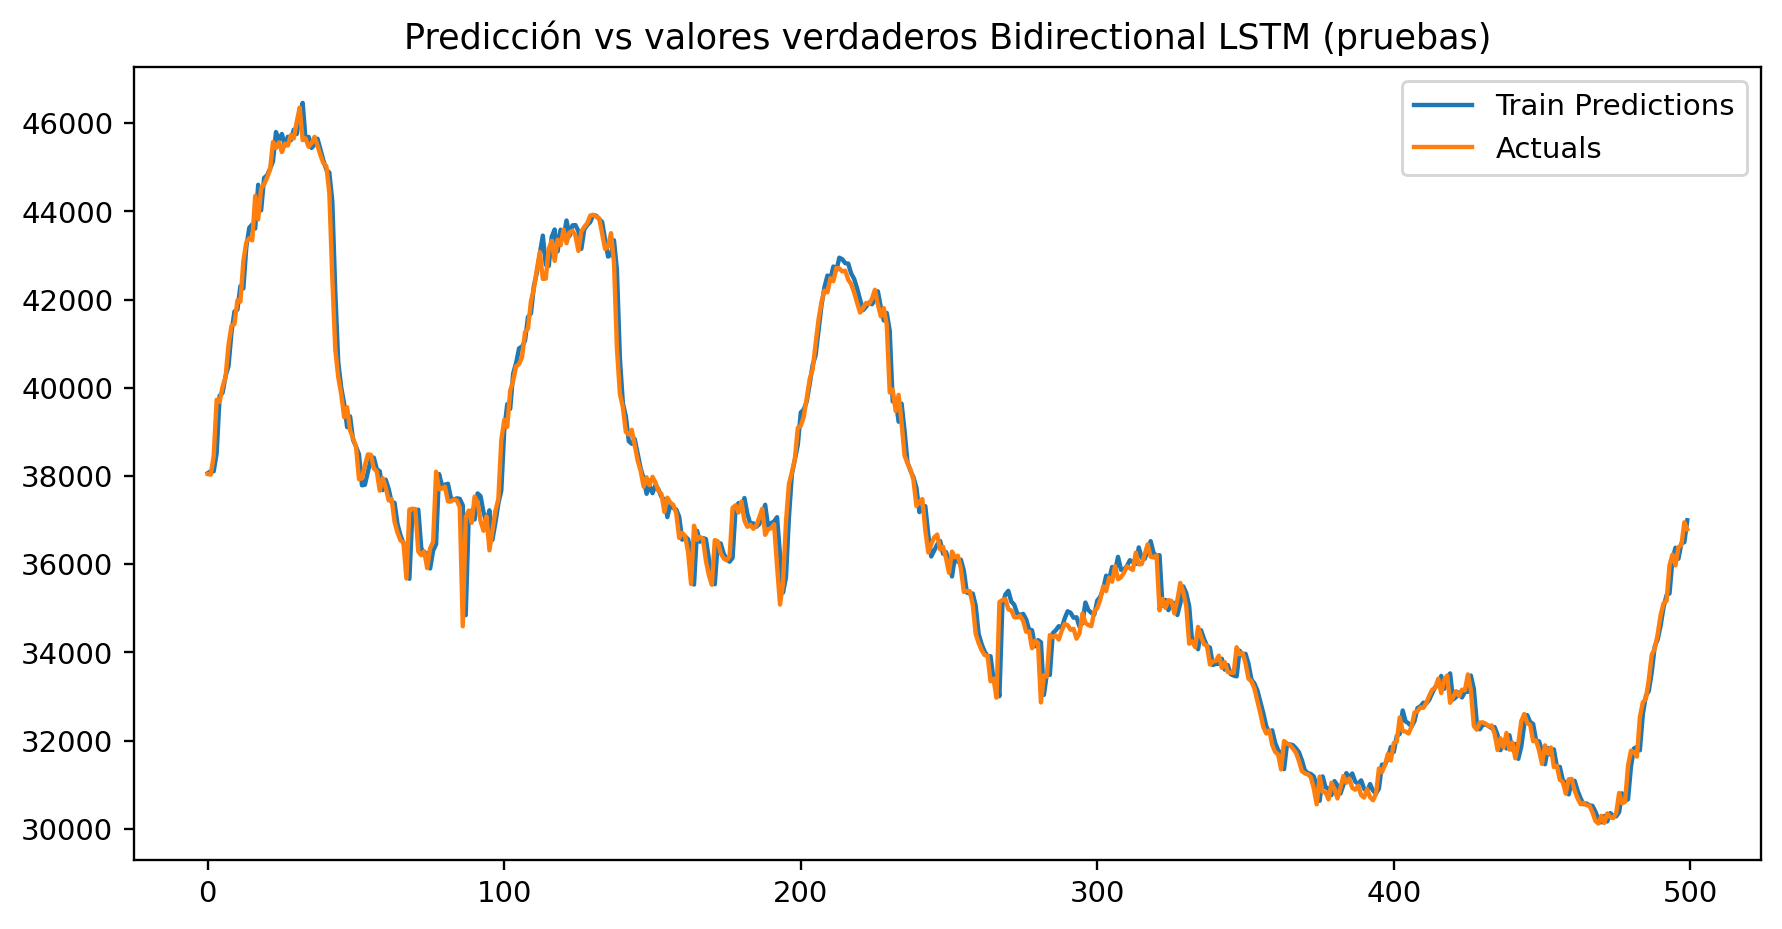

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results_real2["Train Predictions"][:500],label="Train Predictions")
plt.plot(train_results_real2["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos Bidirectional LSTM (pruebas)")
plt.legend();

## Métricas de medición Bidirectional LSTM

### Mean absolute Error

In [49]:
# calculamos mean absolute error
from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(y_test1, prediccion1)
print('MAE: %f' % mae1)

MAE: 0.009591


### Mean Squared Error

In [50]:
# calculamos mean squared error
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(y_test1, prediccion1)
print('MSE: %f' % mse1)

MSE: 0.000206


### Root Mean Squared Error

In [51]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
mse1 = mean_squared_error(y_test1, prediccion1)
rmse1 = sqrt(mse1)
print('RMSE: %f' % rmse1)

RMSE: 0.014366


### Mean absolute percentage error 

In [52]:
mape1 = mean_absolute_percentage_error(y_test1,prediccion1)
print('MAPE: %f' % mape1)

MAPE: 3.973598


-------------------------------------------------------------------------------------

# Perceptron Multicapa (Redes Neuronales artificiales)

Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería Scikit-learn (sklearn) y varias de sus funciones y conjuntos de datos.

In [53]:
# scikit-learn y algunos módulos específicos
import sklearn


# Selección del modelo
from sklearn.model_selection import train_test_split   #Subconjuntos de entrenamiento y pruebas.
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold #Validación cruzada de K-pliegues.
from sklearn.model_selection import GridSearchCV  #Búsqueda en cuadrícula de hiperparámetros.

# Selección de los datos en series de tiempo
from sklearn.model_selection import TimeSeriesSplit

# Clasificadores
from sklearn.linear_model import LogisticRegression #Regresión logística. (Clasificación lineal)
from sklearn.neural_network import MLPClassifier    #Clasificador con red neuronal de tipo percetron multicapa.

# Regresores
from sklearn.neural_network import MLPRegressor    #Regresor con red neuronal de tipo percetron multicapa.

# Métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error #Error absoluto, cuadrado, y cuadrado logarítmico.

Se importan librerías básicas de python y se cambia al formato retina de matplotlib para una mejor visualización

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')

# Librerías básicas NumPy, Pandas y Matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

Se realiza la lectura del dataset y se convierte a una serie para una mejor lectura 

In [55]:
df_3 = pd.read_csv(url,usecols=[0,1],index_col = 0,parse_dates= True)
df4 = df_3.sort_values(by=['DateTime']).squeeze()
df4


DateTime
2018-01-01 00:00:00    28947.06
2018-01-01 00:15:00    28779.14
2018-01-01 00:30:00    28737.36
2018-01-01 00:45:00    28700.43
2018-01-01 01:00:00    28648.00
                         ...   
2020-02-29 22:45:00    31552.81
2020-02-29 23:00:00    31364.09
2020-02-29 23:15:00    31236.65
2020-02-29 23:30:00    31096.75
2020-02-29 23:45:00    31650.58
Name: TotalCampusLoad, Length: 75844, dtype: float64

Se prepara el  *dataset* para el modelado. El objetivo es entrenar un **modelo autorregresivo**, en el cual el valor de la serie de tiempo en un momento dado $X_i$ depende de los $k$ valores anteriores. 

La red neuronal debe tener $k$ entradas o *features* y 1 salida, que corresponde al valor actual. Las *features* serán las $k$ observaciones previas, que corresponden a una **ventana** de tamaño $k$. 

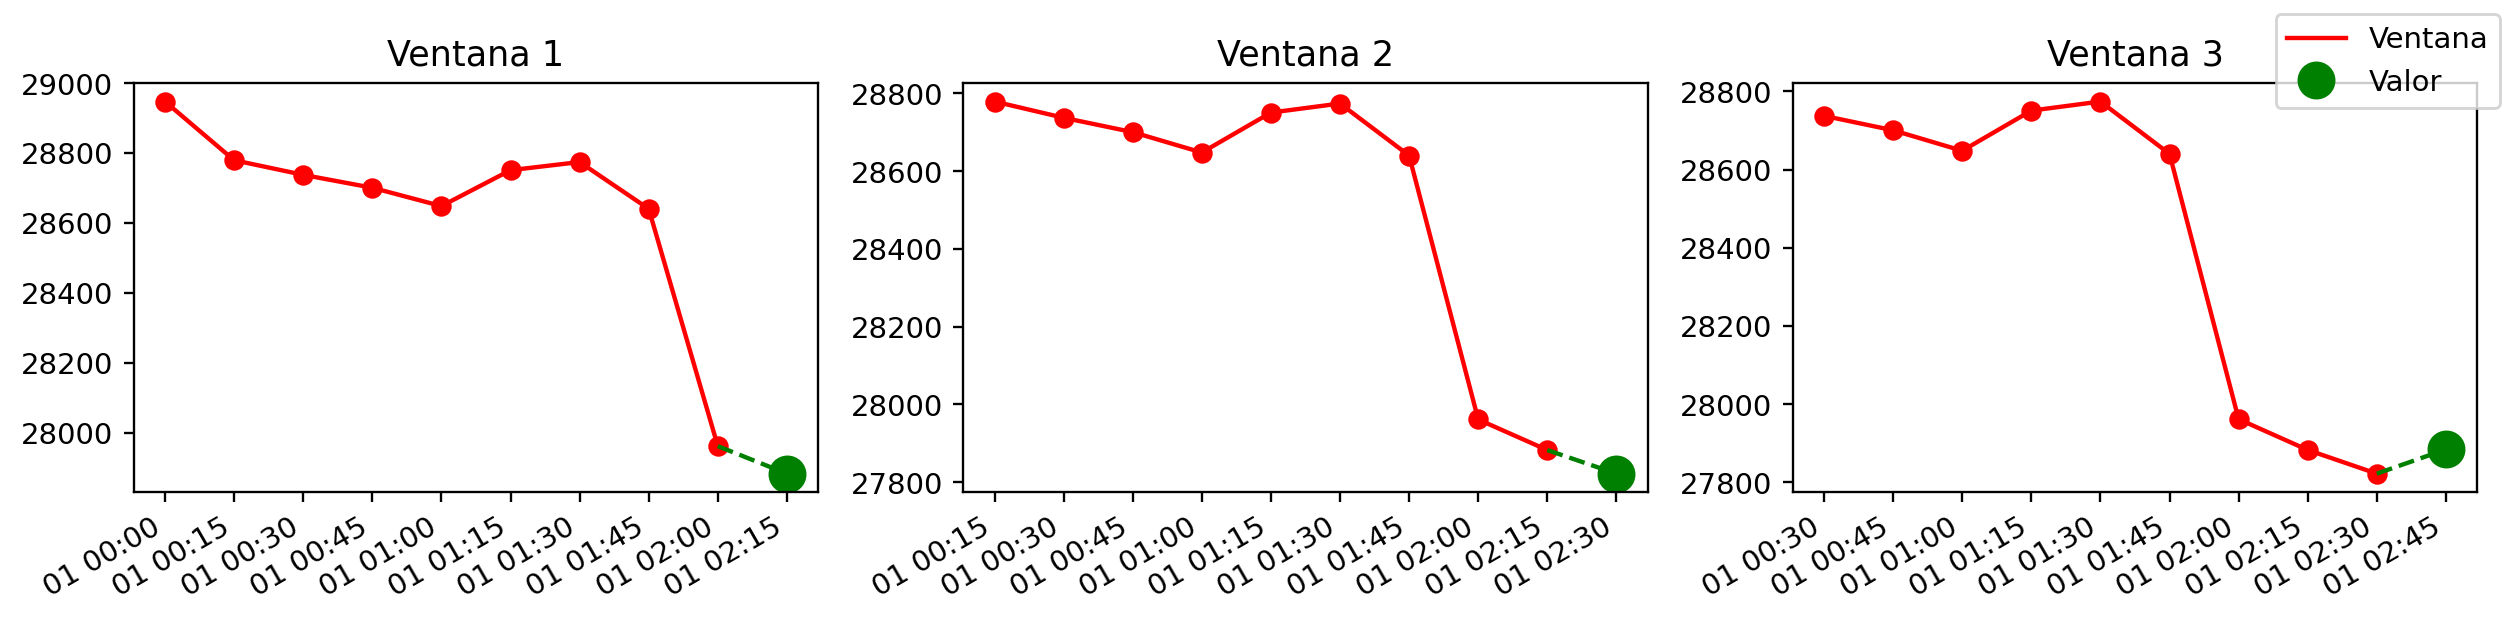

In [56]:
#Visualización del concepto de ventana
n = 3 #Número de ventanas a visualizar
k = 10
fig, ax = plt.subplots(ncols = n, figsize = (4*n, 3), dpi = 105)

for i in range(n):
  data =  df4.iloc[i: i + k]
  ax[i].set_title(f'Ventana {i + 1}')
  ax[i].plot(data.index[:-1], data.values[:-1], 'r')
  ax[i].plot(data.index[-1], data.values[-1], 'go', ms = 12)  
  ax[i].plot(data.index[:-1], data.values[:-1], 'ro')
  ax[i].plot(data.index[-2:], data.values[-2:], 'g--')
  fig.autofmt_xdate()
fig.tight_layout()

fig.legend(['Ventana', 'Valor']);

Podemos generar nuestro modelo con una ventana de 96 observaciones, como se mencionaba anteriormente. Es decir:


In [57]:
k = 96


Se usa el 80 % del conjunto de datos para entrenamiento y validación y el otro 30% para el conjunto de pruebas. Se almacena en un arreglo de Numpy

In [58]:
data_train = df4.iloc[:60598]  #80 % de los datos para entrenamiento
data_test = df4.iloc[60598:]   #20 % de los datos para prueba 

data_train.index[-1], data_test.index[0] #Fechas de final del dataset de entrenamiento y principio de prueba de ambos conjuntos.

(Timestamp('2019-09-24 05:15:00'), Timestamp('2019-09-24 05:30:00'))

In [59]:
# Función para obtener las ventanas de tiempo.

def sliding_time(ts, window_size=1):

  n = ts.shape[0] - window_size  

  X = np.empty((n, window_size))
  y = np.empty(n)

  for i in range(window_size, ts.shape[0]):   
    y[i - window_size] = ts[i]
    X[i- window_size, 0:window_size] = np.array(ts[i - window_size:i])
    
  return X, y

In [60]:
#Creamos las ventanas y sus valores a predecir para entrenamiento y validación.
X_train4, y_train4 = sliding_time(data_train.values, window_size=k) 

In [61]:
print(f"Número de ejemplos de entrenamiento en x: {X_train4.shape[0]} (Ventana de tamaño {X_train4.shape[1]})")
print(f"Número de valores de entrenamiento en y : {y_train4.shape[0]}")

Número de ejemplos de entrenamiento en x: 60502 (Ventana de tamaño 96)
Número de valores de entrenamiento en y : 60502


In [62]:
#Creamos las ventanas y sus valores a predecir para entrenamiento y validación.
X_test4, y_test4 = sliding_time(data_test.values, window_size=k) 

In [63]:
print(f"Número de ejemplos de prueba: {X_test4.shape[0]} (Ventana de tamaño {X_test4.shape[1]})")
print(f"Número de valores a predecir: {y_test4.shape[0]}")

Número de ejemplos de prueba: 15150 (Ventana de tamaño 96)
Número de valores a predecir: 15150


La fila $X_i$ de $X$ corresponde a una ventana de los $k$ valores anteriores a $y_i$. En la siguiente celda podemos ver el arreglo en formato de *DataFrame*. Note que cada fila es la fila anterior corrida un movimiento hacia la izquierda.

In [64]:
pd.DataFrame(X_train4)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,28947.06,28779.14,28737.36,28700.43,28648.00,28750.72,28774.00,28640.13,27961.41,27882.67,...,28808.35,28730.04,28676.77,28190.46,28019.21,28020.05,28279.84,29151.89,28936.00,29013.26
1,28779.14,28737.36,28700.43,28648.00,28750.72,28774.00,28640.13,27961.41,27882.67,27822.02,...,28730.04,28676.77,28190.46,28019.21,28020.05,28279.84,29151.89,28936.00,29013.26,28913.79
2,28737.36,28700.43,28648.00,28750.72,28774.00,28640.13,27961.41,27882.67,27822.02,27884.12,...,28676.77,28190.46,28019.21,28020.05,28279.84,29151.89,28936.00,29013.26,28913.79,28770.29
3,28700.43,28648.00,28750.72,28774.00,28640.13,27961.41,27882.67,27822.02,27884.12,28411.32,...,28190.46,28019.21,28020.05,28279.84,29151.89,28936.00,29013.26,28913.79,28770.29,28836.83
4,28648.00,28750.72,28774.00,28640.13,27961.41,27882.67,27822.02,27884.12,28411.32,28276.04,...,28019.21,28020.05,28279.84,29151.89,28936.00,29013.26,28913.79,28770.29,28836.83,28672.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60497,38674.43,38817.65,38699.75,38623.71,39051.46,38587.25,38034.98,38021.69,38769.06,38433.31,...,33916.09,33953.98,34029.43,33889.40,33840.87,33833.69,33977.97,33717.06,33746.54,33957.80
60498,38817.65,38699.75,38623.71,39051.46,38587.25,38034.98,38021.69,38769.06,38433.31,38977.17,...,33953.98,34029.43,33889.40,33840.87,33833.69,33977.97,33717.06,33746.54,33957.80,34073.39
60499,38699.75,38623.71,39051.46,38587.25,38034.98,38021.69,38769.06,38433.31,38977.17,39484.75,...,34029.43,33889.40,33840.87,33833.69,33977.97,33717.06,33746.54,33957.80,34073.39,33579.34
60500,38623.71,39051.46,38587.25,38034.98,38021.69,38769.06,38433.31,38977.17,39484.75,39538.81,...,33889.40,33840.87,33833.69,33977.97,33717.06,33746.54,33957.80,34073.39,33579.34,33558.06


En $y_i$ está el elemento que iría justo después de el último valor de la ventana $X_i$. También debemos tener en cuenta que  el elemento $y_i$ es el último valor de la fila $X_{i+1}$, pues en esa ventana pasa a ser el último elemento, usado para predecir el valor $y_{i+1}$.

In [65]:
#Valores a predecir y en formato de Series
pd.Series(y_train4)

0        28913.79
1        28770.29
2        28836.83
3        28672.18
4        28534.72
           ...   
60497    34073.39
60498    33579.34
60499    33558.06
60500    33809.69
60501    34383.24
Length: 60502, dtype: float64

### Partición con los datos de entrenamiento y prueba

Para realizar la partición de los datos de  entrenamiento (traing) y de prueba (test) se debe tomar en cuenta la temporalidad de la serie. Por esto, se usa la función  **`TimeSeriesSplit`** de *Scikit-Learn*.

In [66]:
from sklearn.model_selection import TimeSeriesSplit
# Definimos el número de splits para realizar cross-validation
tsp = TimeSeriesSplit(n_splits=5)

EL método **`TimeSeriesSplit`** toma como parámetro los arreglos **`X`** y **`y`** y genera los índices para entrenamiento y pruebas de una validación cruzada de **forward chaining** igual a la cantidad de divisiones definidas en el argumento **`n_splits`**. 

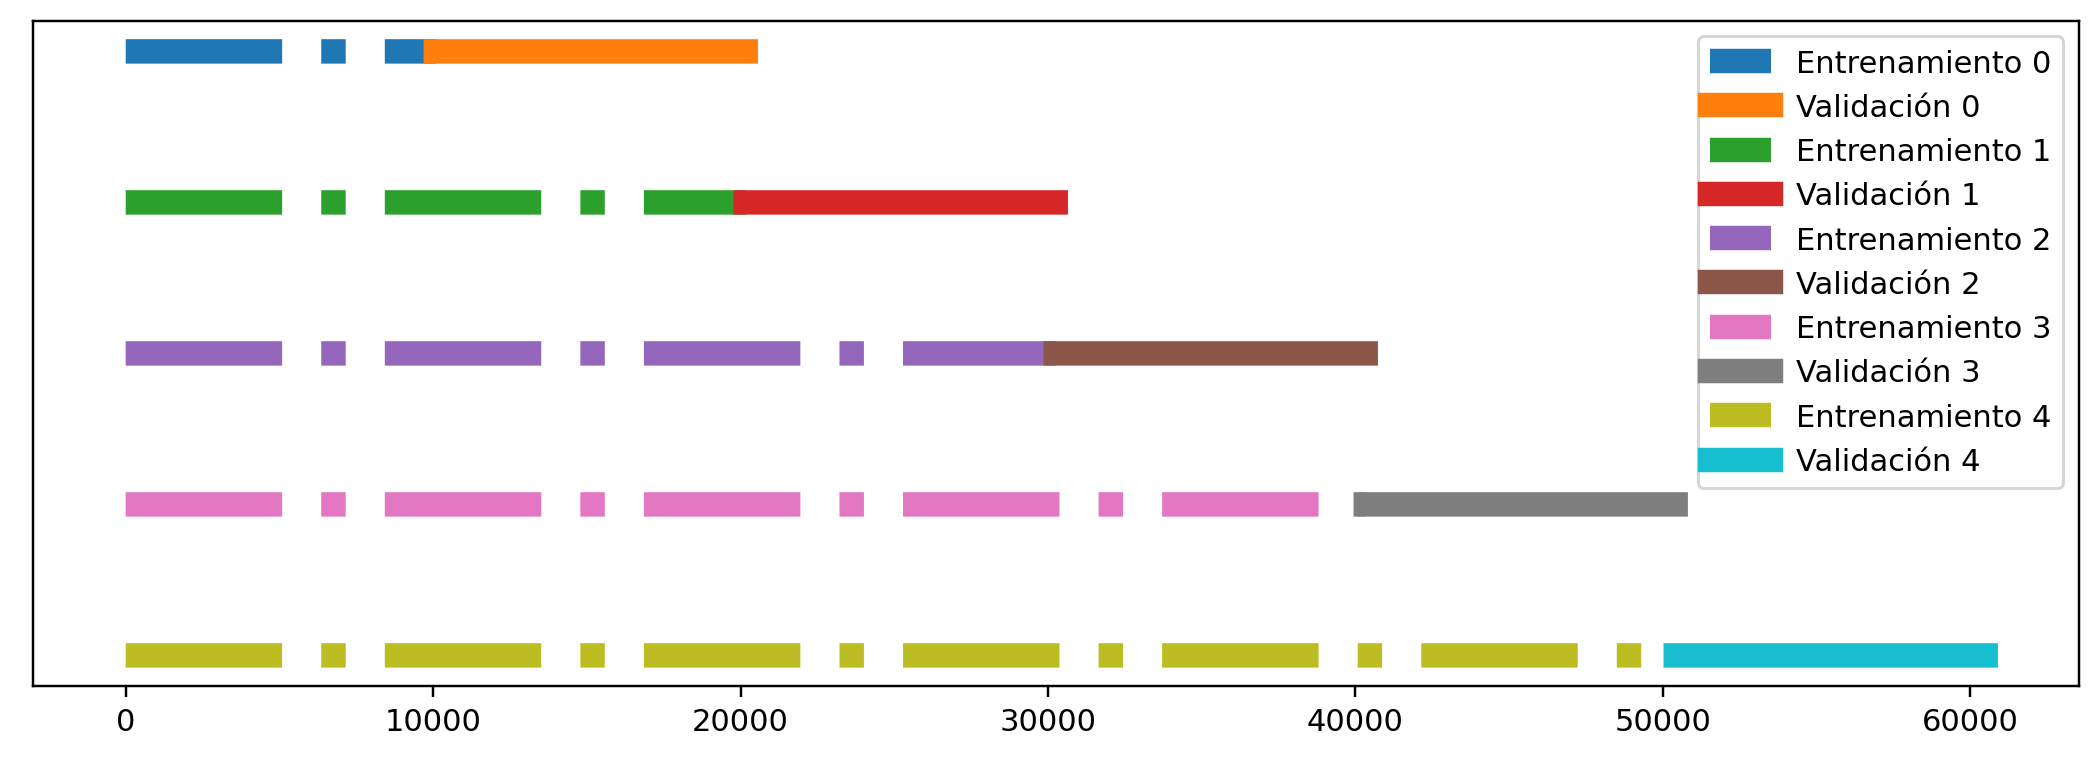

In [67]:
i = 0
fig = plt.figure(figsize = (12,4), dpi = 110)
plt.set_cmap('Paired')

tsp_indexes = [(train4_index, test4_index) for (train4_index, test4_index) in tsp.split(X_train4, y_train4)]

for train4_index, test4_index in tsp_indexes:
  plt.plot(train4_index, 
           np.full(len(train4_index), 1-i*0.001),
           lw = 8, 
           ls= '-.', 
           label = f'Entrenamiento {i}')
  
  plt.plot(test4_index, 
           np.full(len(test4_index), 1-i*0.001), 
           lw = 8, 
           ls= '-', 
           label = f'Validación {i}')
  i+=1
fig.get_axes()[0].get_yaxis().set_visible(False)
plt.legend();

Se visualizan los datos de entrenamiento y valicación de la última división :

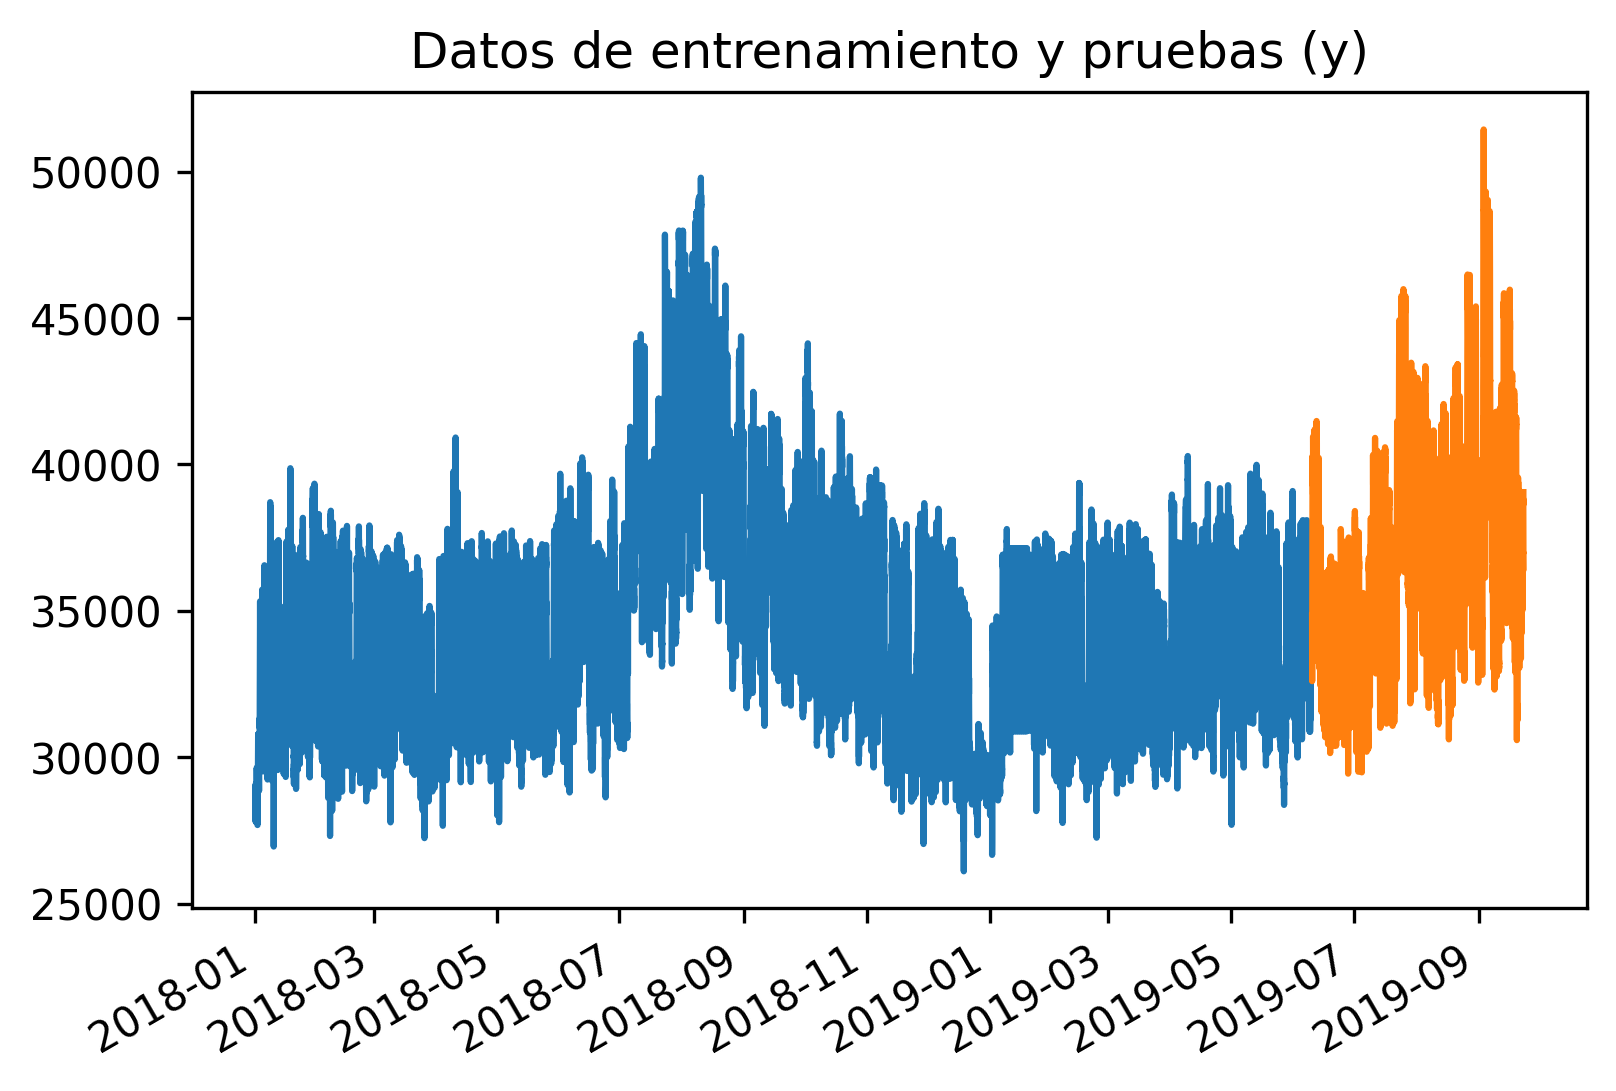

In [68]:
#Datos de prueba y entrenamiento con Matplotlib
train4_index, test4_index = tsp_indexes[-1]

fig = plt.figure(dpi = 150)
plt.plot(df4[train4_index].index, df4[train4_index].values, label = "Entrenamiento (y)")
plt.plot(df4[test4_index].index, df4[test4_index].values, label = "Prueba (y)")

plt.title('Datos de entrenamiento y pruebas (y)')
fig.autofmt_xdate()

## Regresión de series de tiempo con perceptrón multicapa
---
Ahora realizamos la regresión con una red neuronal multicapa, para predecir el valor de la serie. En esta ocasión utilizaremos **`MPLRegressor`**. Sus parámetros son equivalentes a los aceptados por **`MLPClassifier`**, a diferencia que el regresor permite retornar los valores continuos generados por la función de predicción.

In [69]:
#from sklearn.neural_network import MLPRegressor 

model_perceptron = MLPRegressor(solver = 'adam',
                   activation = 'relu',
                   hidden_layer_sizes=(120, 60, 30),
                   max_iter=200,                   
                   n_iter_no_change=50, 
                   validation_fraction=0.2,               
                   random_state=1234)

In [70]:
#Entrenamos el modelo
model_perceptron.fit(X_train4, y_train4)

MLPRegressor(hidden_layer_sizes=(120, 60, 30), n_iter_no_change=50,
             random_state=1234, validation_fraction=0.2)

In [71]:
y_pred4 = model_perceptron.predict(X_test4)

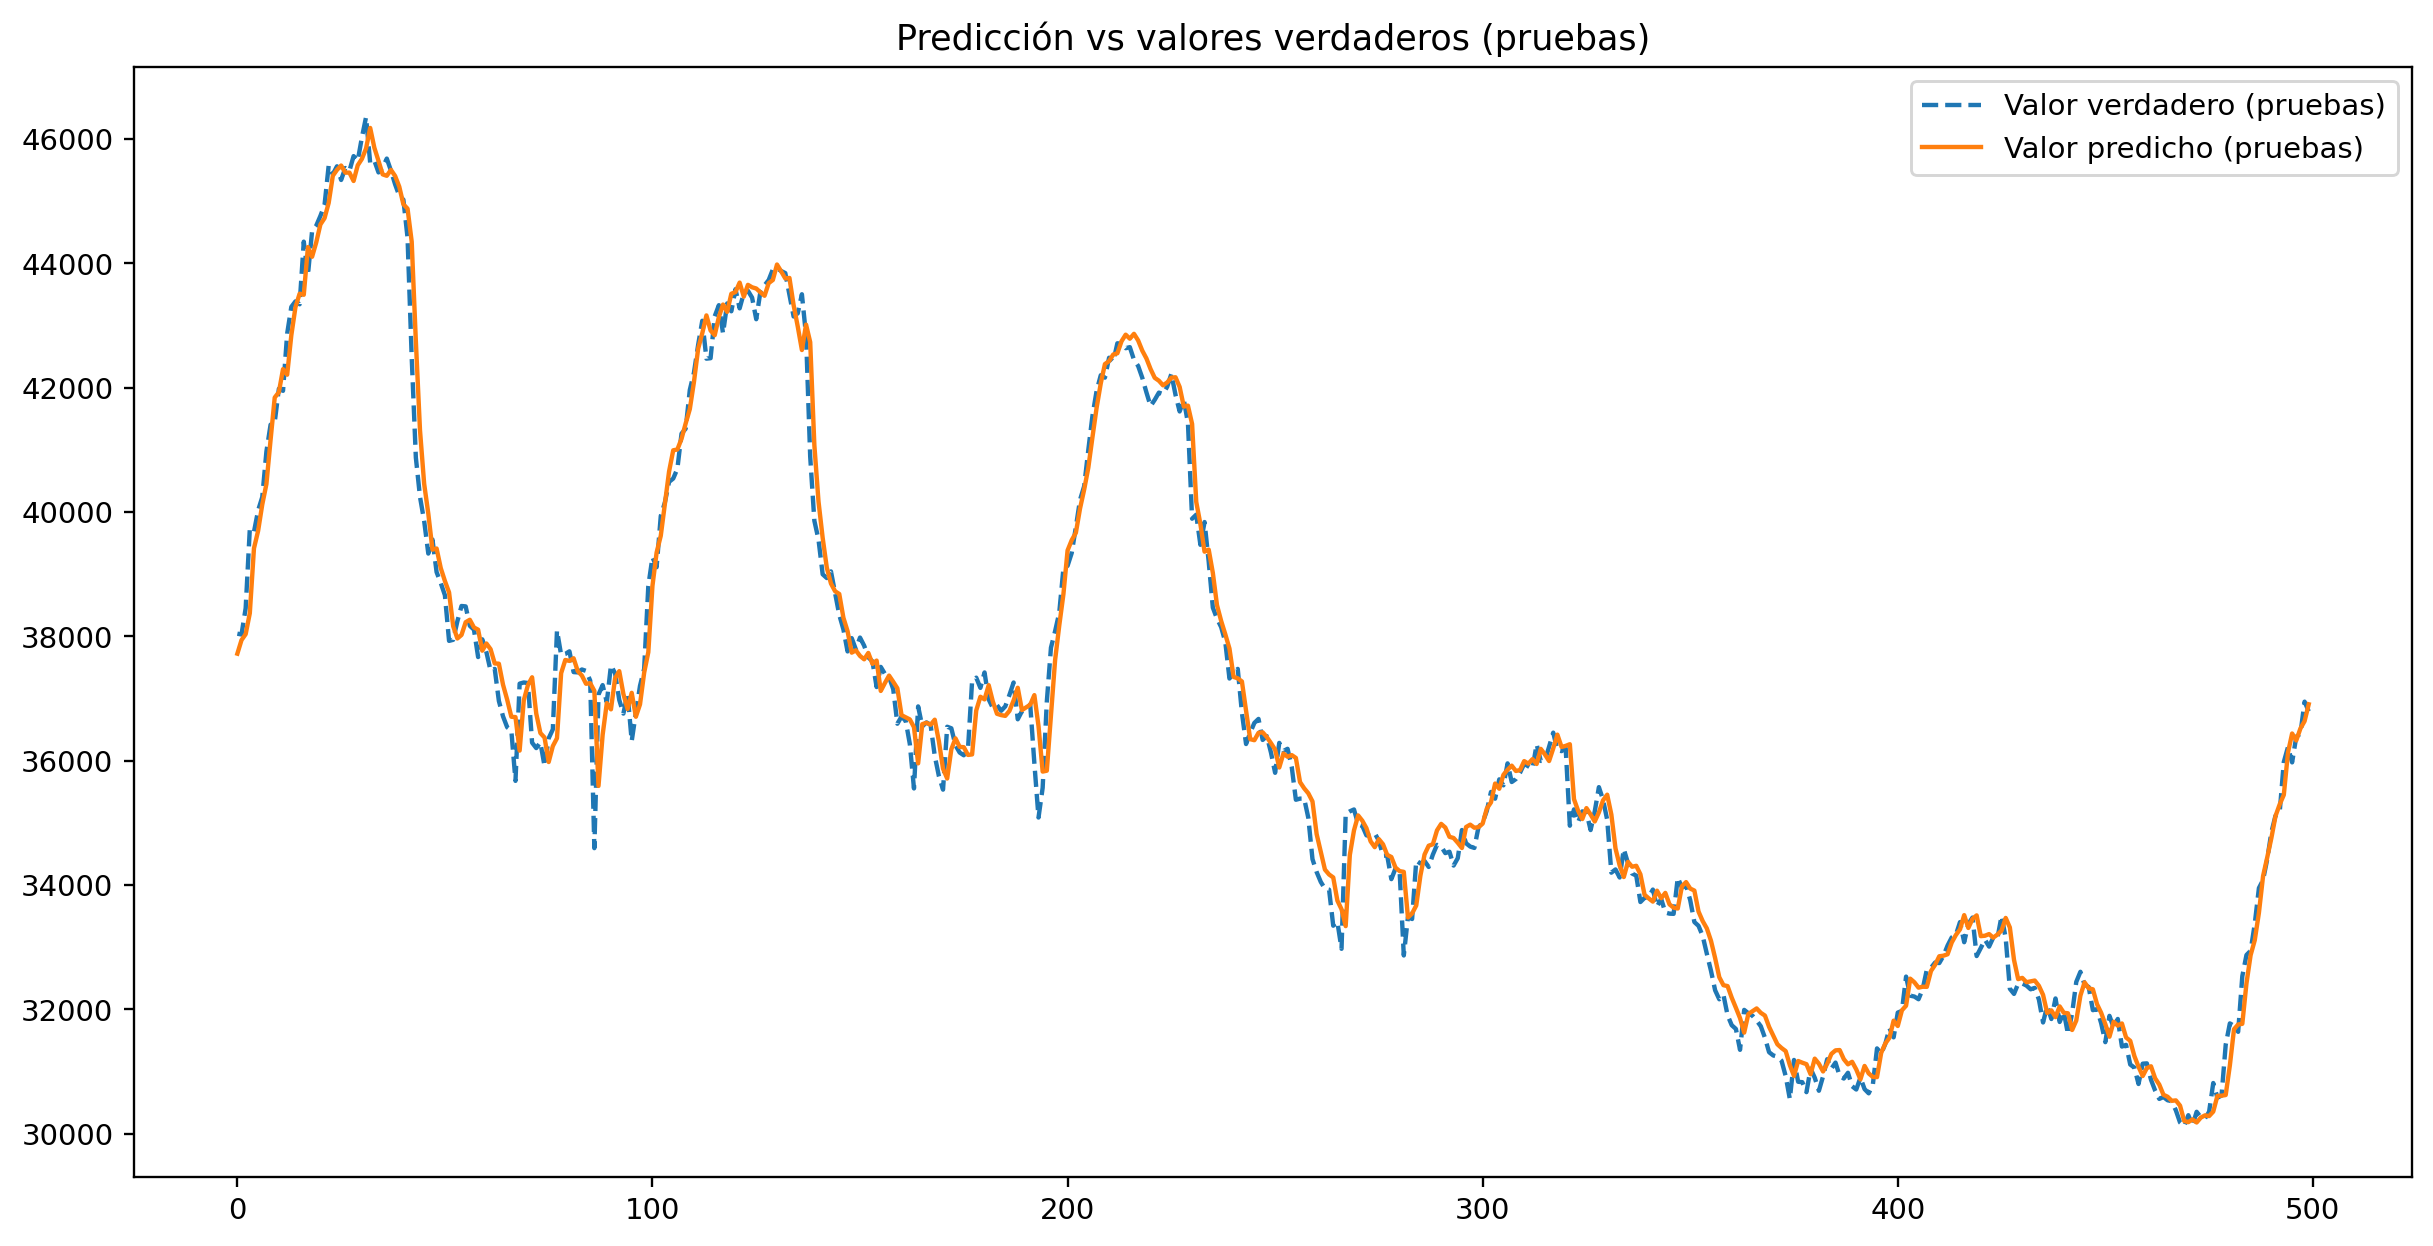

In [72]:
x = data_test.index[k:]

plt.figure(figsize=(14,7), dpi = 105)
plt.plot(y_test4[:500], ls = "--", label="Valor verdadero (pruebas)")
plt.plot(y_pred4[:500], ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas)")
plt.legend();

In [73]:
print(f"Test Mean Squared Error: {mean_squared_error(y_test4, y_pred4)}")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test4, y_pred4)}")
print(f"Test Mean squared log error: {mean_squared_log_error(y_test4, y_pred4)}")
mape = mean_absolute_percentage_error(y_test4,y_pred4)
print('Mean absolute percentage error (MAPE): %f' % mape)

Test Mean Squared Error: 136130.02084055613
Test Mean Absolute Error: 249.48920410659932
Test Mean squared log error: 0.0001246416301432533
Mean absolute percentage error (MAPE): 0.742289
